# Analysing the Prices of London Properties

The notebook uses the Zoopla Property API (Foursquare didnt have sufficient London Data) to analyse the prices of London property that are currently on the market.   Data is fetched through the Zoopla API and subjected to statistical techniques to understand the influential variables of property price.

There is also a trained and scored machine learning algortithm which can be utilised to predict a house price based upon the variables taken from the Zoopla API.

In [1]:
#installs

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
!pip install rightmove-webscraper
!pip install zoopla

    100% |████████████████████████████████| 51kB 2.7MB/s ta 0:00:01


In [1]:
# import required libraries 
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from bs4 import BeautifulSoup
import re
from pandas.io.json import json_normalize



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [ ]:
from rightmove_webscraper import rightmove_data
from zoopla import Zoopla

# Input for API Scraper

First we take all the postcodes that make up our area of London, along with other settings that we need to put into our web scraper

In [ ]:
postcodes_start = ['W7','W5','HA0','UB6', 'W3', 'NW10', 'UB1']
APIlisting_status = 'sale'
APIminimum_beds = '1' 
APImaximum_beds = '4'
APIminimum_price = '400000'
APImaximum_price = '800000'
APIproperty_type = 'flats'


## API Limits 100 records per fetch, therefore necessary to import all of the required postcodes through separate api calls and then combine them

In [8]:
#Import w5 data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': APIlisting_status,
    'area': 'W5',
    'minimum_beds': APIminimum_beds,    
    'maximum_beds': APImaximum_beds,
    'minimum_price': APIminimum_price,
    'maximum_price': APImaximum_price,
    'property_type': APIproperty_type,
    'page_size': 1000
})

w5_data = search.listing
w5 = pd.DataFrame.from_records(w5_data)
w5.shape

(100, 28)

In [9]:
#Import w7 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'W7',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

w7_data = search.listing
w7 = pd.DataFrame.from_records(w7_data)
w7.shape

(26, 28)

In [10]:
#Import HA0 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'HA0',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

ha0_data = search.listing
ha0 = pd.DataFrame.from_records(ha0_data)
ha0.shape

(34, 28)

In [13]:
#Import ub6 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'UB6',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

ub6_data = search.listing
ub6 = pd.DataFrame.from_records(ub6_data)
ub6.shape

(10, 28)

In [14]:
#Import w3 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'W3',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

w3_data = search.listing
w3 = pd.DataFrame.from_records(w3_data)
w3.shape

(100, 28)

In [15]:
#Import nw10 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'NW10',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

nw10_data = search.listing
nw10 = pd.DataFrame.from_records(nw10_data)
nw10.shape

(100, 28)

In [16]:
#Import ub1 Data

zoopla = Zoopla(api_key='jgv7hvyk5aebtc6ktm7fat9m')

search = zoopla.property_listings({
    'listing_status': 'sale',
    'area': 'UB1',
    'minimum_beds': '1',    
    'maximum_beds': '4',
    'minimum_price': '400000',
    'maximum_price': '800000',
    'property_type': 'flats',
    'page_size': 1000
})

ub1_data = search.listing
ub1 = pd.DataFrame.from_records(ub1_data)
ub1.shape

(8, 28)

After importing the initial data set with no filtering at source, it was noticed that there were a high number of anomalies in the dataset, therefore the data was filtered at source, to ensure that we are only taking records with more than 0 bedrooms.

In [17]:
zdf = pd.concat([w7, w5, ha0, ub6, w3, nw10, ub1], ignore_index=True)


In [19]:
cats = ['category', 'displayable_address','latitude','longitude','num_bathrooms', 'num_bedrooms', 'num_recepts', 'outcode', 'price','property_type', 'street_name']

zdf = zdf[cats]

zdf.to_csv('output.csv')

### Exported to CSV then imported to ensure the data set is static, houses are constantly being added and removed, we require a static dataset to ensure accurate analysis, we can remove this later.

In [2]:
zdf1 = pd.read_csv('output.csv')
zdf1 = zdf1.drop('Unnamed: 0', axis=1)
zdf1.head()

,category,displayable_address,latitude,longitude,num_bathrooms,num_bedrooms,num_recepts,outcode,price,property_type,street_name
0,Residential,"Lawn Gardens, London W7",51.509914,-0.340887,2,3,1,W7,565000.0,Maisonette,Lawn Gardens
1,Residential,"Tennyson Road, London W7",51.512817,-0.335709,1,2,1,W7,550000.0,Maisonette,47 Tennyson Road
2,Residential,"Church Road, London W7",51.511475,-0.335383,1,2,1,W7,500000.0,Flat,Church Road
3,Residential,"Greenford Avenue, Hanwell, London W7",51.517693,-0.338327,0,3,0,W7,499950.0,Maisonette,Hanwell
4,Residential,"Greenford Avenue, Hanwell W7",51.517693,-0.338327,2,3,1,W7,499950.0,Maisonette,Greenford Avenue


In [5]:
#Examine NA in Zoopla dataset
nazoop = (zdf1.isnull().sum() / len(zdf1)*100).sort_values(ascending=False)
nazooptotal = zdf1.isnull().sum().sort_values(ascending=False)
missingdata = pd.concat([nazoop, nazooptotal], axis=1, keys=['%', 'Total # Records'])[:30]
missingdata.head()

,%,Total # Records
street_name,1.587302,6
property_type,0.529101,2
price,0.000000,0
outcode,0.000000,0
num_recepts,0.000000,0


There are outliers where the price was 0, these records need to be dropped.

In [3]:
zdf1.shape

(378, 11)

In [3]:
# Get names of indexes for which column price has a value of 0
indexNames = zdf1[zdf1['price'] == 0].index
 
# Delete these row indexes from dataFrame
zdf1.drop(indexNames , inplace=True)





In [27]:
zdf1.shape

(373, 11)

Remove any rows where the number of bathrooms is zero.

In [4]:
# Get names of indexes for which column bathrooms has a value of 0
indexNames = zdf1[zdf1['num_bathrooms'] == 0].index
 
# Delete these row indexes from dataFrame
zdf1.drop(indexNames , inplace=True)

In [29]:
zdf.shape

(378, 11)

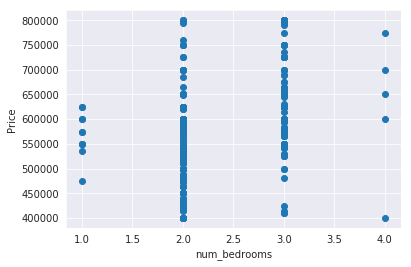

In [5]:
#Scatterplot to check for any outliers
var='num_bedrooms'

fig, ax = plt.subplots()
ax.scatter(x = zdf1[var], y = zdf1['price'])
plt.ylabel('Price', fontsize=10)
plt.xlabel(var, fontsize=10)
plt.show()

#Feature engineering

Change the continuous variables for number of bathrooms and number of bedrooms into categorical variables so they look cleaner in charts. 

In [6]:
#change bedrooms and bathrooms to categorical variables
zdf1['num_bathrooms'] = zdf1['num_bathrooms'].astype(str)
zdf1['num_bedrooms'] = zdf1['num_bedrooms'].astype(str)

# Analyse the Relationship between bedrooms and Price

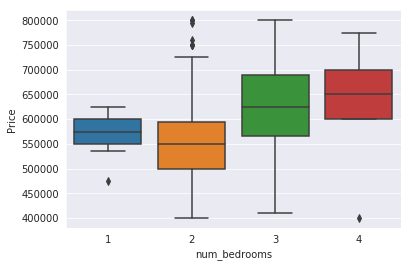

In [7]:
#Scatterplot to investigate any high level parrterns
var='num_bedrooms'

fig, ax = plt.subplots()
sns.boxplot(x = zdf1[var], y = zdf1['price'])
plt.ylabel('Price', fontsize=10)
plt.xlabel(var, fontsize=10)
plt.show()

This boxplot shows that there is a steady increase between the value of 2-3-4 bedroom properties. A second bedroom costs aproximmately £30K, whilst a 3rd bedroom mosts an additional £10K GBP.

Points to be investigated further 
- what is causing the average price of a one bed property to be significantly higher than that of a two bed property?

# Analyse the Relationship between bathrooms and Price

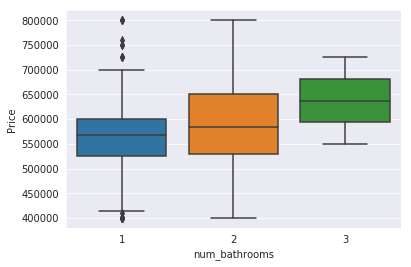

In [8]:
#Scatterplot to investigate any high level patterns relating to number of bathrooms.
var='num_bathrooms'

fig, ax = plt.subplots()
sns.boxplot(x = zdf1[var], y = zdf1['price'])
plt.ylabel('Price', fontsize=10)
plt.xlabel(var, fontsize=10)
plt.show()

This boxplot shows us that as expected, a 2 bathroom property is more expensive than a 1 bathroom property.  On average a second bathroom costs £20,000! and a third a further 60,000 (were in house territory with 3 bathrooms, so this isnt surprising) 



## Why are one beds priced so highly in this analysis? 

In [9]:
#create a dataset using only 1 beds
onebeds = zdf1.loc[zdf1['num_bedrooms'] == '1' ]
onebeds.head(200)

,category,displayable_address,latitude,longitude,num_bathrooms,num_bedrooms,num_recepts,outcode,price,property_type,street_name
69,Residential,"Filmworks Walk, Ealing W5",51.513775,-0.306980,1,1,0,W5,624950.0,Flat,Filmworks Walk
70,Residential,"Longfield Avenue, Dickens Yard W5",51.513740,-0.306087,1,1,1,W5,624000.0,Flat,Longfield Avenue
76,Residential,"Vista House, 2 New Broadway W5",51.513306,-0.306348,1,1,1,W5,600000.0,Flat,Dickens Yard
83,Residential,"Bond Street, Ealing W5",51.513775,-0.306980,1,1,0,W5,599950.0,Flat,Bond Street
102,Residential,"Fitzroy House, Dickens Yard, Ealing W5",51.513520,-0.306917,1,1,1,W5,575000.0,Flat,Dickens Yard
103,Residential,"Vista House, London W5",51.513740,-0.306087,1,1,0,W5,575000.0,Flat,Vista House
141,Residential,"Northwick Road, London HA0",51.538740,-0.302232,1,1,0,HA0,475000.0,NaN,Northwick Road
235,Residential,"Long Island House, 42 Warple Way, Acton W3",51.504204,-0.255261,1,1,1,W3,550000.0,Flat,Island House
238,Residential,"Warple Way, London W3",51.504204,-0.255261,1,1,1,W3,550000.0,Flat,Warple Way
242,Residential,"Long Island House, 42 Warple Way, London W3",51.504204,-0.255261,1,1,1,W3,550000.0,Flat,42 Warple Way London


I believe the skew in one bed apartments data - i.e. the one beds costing so much more - is caused by the fact that there is much more demand for one bed apartments in london (as this is all that most can afford with government schemes, therefore more of these are being built.  Newbuilds are generally more expensive, so an analysis will have to be compelted into the age of the building and how this correllates to the price. 

The next piece of analysis will investigate if the postcode has an impact of price - this could also be a cause for highly priced one-beds as we can see that one beds are mostly located in the W3 and W5 Postcodes. 

# Analyse the Relationship Between Postcode and Price

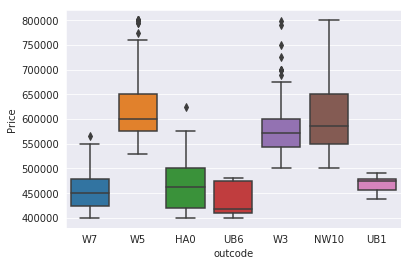

In [10]:
#Scatterplot to investigate Price vs Postcode.
var='outcode'

fig, ax = plt.subplots()
sns.boxplot(x = zdf1[var], y = zdf1['price'])
plt.ylabel('Price', fontsize=10)
plt.xlabel(var, fontsize=10)
plt.show()

The above box plot confirms that the postcode does have an impact on the price - in fact it appears to have a highly significant impact - it also supports the hypothesis that one-beds are more expensive because they are mostly located in W5 and W3, the more expensive areas. 

# Add in public transport stations

In order to map the properties and their location in regard to proximity of transport links, we need to import the coordinates of all London transport links download ed from Transport For London.  Then filter them by just the postcodes we are looking to analyse. 

In [11]:
#import 
trains = pd.read_csv('London_stations.csv')


In [12]:
pc = postcodes_start
westtrains = trains[trains.outcode.isin(pc)]
westtrains.shape

(28, 8)

# Map the data

Lets produce an interactive map using the station and property price data we have - we can select a point on the map to see more information about the point.  

In [13]:
import folium
from folium import plugins

In [14]:
map_base = zdf1
map_base['price'] = map_base['price'].astype(str)

In [19]:
#Interactive map showing location and price
# mark each station as a point
m = folium.Map([51.513773, -0.306980] ,zoom_start=11)

for index, row in map_base.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['price'],
                        fill_color="#e4563d", # point color
                       ).add_to(m)
    
for index, row in westtrains.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                        #radius=30,
                        popup=row['Station'],
                        #fill_color="#63e43d", # point color
                       ).add_to(m)   
    
    #Heatmap showing concentration of properties
# convert to (n, 2) nd-array format for heatmap
#propertyArr = map_base[['latitude', 'longitude']].as_matrix()

# plot heatmap
#m.add_children(plugins.HeatMap(propertyArr, radius=15))
 
    
m

# Create Linear Regression Model for Predictions

Import necessary libraries

In [27]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder

Clear down dataset, only use variables that help us predict.

In [29]:
train_cols = ['price', 'outcode', 'num_bathrooms', 'num_bedrooms', 'num_recepts']
train = zdf1[train_cols]
train['num_recepts'] = train['num_recepts'].astype(str)
train['outcode'] = train['outcode'].astype(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 377
Data columns (total 5 columns):
price            333 non-null object
outcode          333 non-null object
num_bathrooms    333 non-null object
num_bedrooms     333 non-null object
num_recepts      333 non-null object
dtypes: object(5)
memory usage: 25.6+ KB


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
# Split Data set into X and Y - X is the features, Y is the varible we want to predict.
X = train
X = train.drop(['price'], axis=1) #remove when using test data
y = train['price'] #remove when using test data

### We need to label encode the dataset so it is accepted by the RF algorithm

In [48]:
#encode outcode column
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X['outcode'] = le.fit_transform(X.outcode.values)

### Model 1 - Lasso

In [50]:
# Select an alpha - Trail and Error or Cross Validation - will expand on this.
best_alpha = 0.00099

#Train the Model
regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X, y)

#Predict using X as our parameters
lasso_test_predictions = regr.predict(X)
print(lasso_test_predictions)



[529608.49876353 445962.76291834 445962.76291834 529608.49876353
 455374.03316319 505653.98488712 445962.76291834 445962.76291834
 445962.76291834 455374.03316319 455374.03316319 445962.76291834
 445962.76291834 445962.76291834 445962.76291834 455374.03316319
 445962.76291834 447939.80192293 445962.76291834 445962.76291834
 445962.76291834 432612.51104035 617656.30918408 631884.66038558
 644789.496277   617656.30918408 692103.07527514 692103.07527514
 692103.07527514 692103.07527514 644789.496277   698052.23099588
 631884.66038558 692103.07527514 644789.496277   631884.66038558
 644789.496277   631884.66038558 644789.496277   631884.66038558
 631884.66038558 611571.79166553 692103.07527514 644789.496277
 644789.496277   631884.66038558 655084.89938716 617656.30918408
 627407.40580702 644789.496277   692103.07527514 644789.496277
 611571.79166553 631884.66038558 644789.496277   644789.496277
 692103.07527514 617656.30918408 617656.30918408 599008.26963038
 615956.79611436 644789.496277 

### Model 2 - Random Forest

In [51]:
#fit random forest model

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [52]:
#Predict using X as our parameters
rf_test_predictions = rf_model.predict(X)
print(rf_test_predictions)

[529858.75       444116.96914197 444116.96914197 529858.75
 452754.16666667 508246.66666667 444116.96914197 444116.96914197
 444116.96914197 452754.16666667 452754.16666667 444116.96914197
 444116.96914197 444116.96914197 444116.96914197 452754.16666667
 444116.96914197 438833.33333333 444116.96914197 444116.96914197
 444116.96914197 412524.80519481 619627.87630936 631354.36197235
 643499.66812634 619627.87630936 693571.29884005 693571.29884005
 693571.29884005 693571.29884005 643499.66812634 729540.41666667
 631354.36197235 693571.29884005 643499.66812634 631354.36197235
 643499.66812634 631354.36197235 643499.66812634 631354.36197235
 631354.36197235 613750.         693571.29884005 643499.66812634
 643499.66812634 631354.36197235 650231.61400697 619627.87630936
 610000.         643499.66812634 693571.29884005 643499.66812634
 613750.         631354.36197235 643499.66812634 643499.66812634
 693571.29884005 619627.87630936 619627.87630936 599386.33333333
 608319.66666667 643499.6681263

Now we have two sets of predictions - we need to ensure that these are put back into the original dataframe, alongside the original property price.   this way we can visualise them to check their performance. 

In [53]:
train['rfpredictions'] = rf_test_predictions
train['laspredictions'] = lasso_test_predictions
train['price'] = train['price'].astype(float)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 377
Data columns (total 8 columns):
price             333 non-null float64
outcode           333 non-null object
num_bathrooms     333 non-null object
num_bedrooms      333 non-null object
num_recepts       333 non-null object
predictions       333 non-null float64
rfpredictions     333 non-null float64
laspredictions    333 non-null float64
dtypes: float64(4), object(4)
memory usage: 33.4+ KB


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


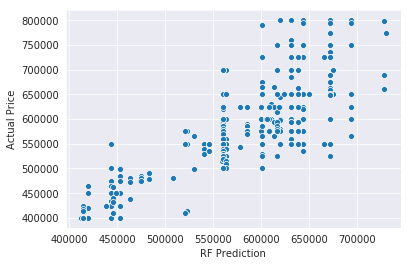

In [56]:
#Graph Targets vs Prediction to see correllation
sns.scatterplot(x=train['rfpredictions'], y=train['price'])
plt.xlabel('RF Prediction')
plt.ylabel('Actual Price')
plt.show()

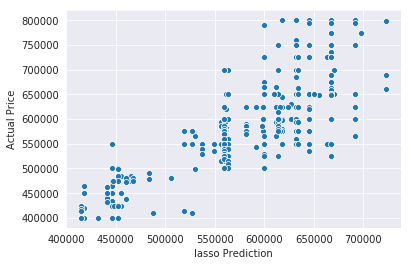

In [55]:
#Graph Targets vs Prediction to see correllation
sns.scatterplot(x=train['laspredictions'], y=train['price'])
plt.xlabel('lasso Prediction')
plt.ylabel('Actual Price')
plt.show()